---
title: "'Incel'ligent Political Conversations "
subtitle: "Hypotheses, rationale, tests, visualizations, decisions"
author: "ezou"
date: "2025-02-20" 
format: 
    html:
        embed-resources: true 
        toc: true 
        toc-depth: 3 
        number-sections: true 
        code-fold: true 
execute: 
    echo: true 
    warning: false
---

# Introduction
One language can contain multitudes; social groups create their own vocabularies—through dialect, slang, or jargon—while still remaining part of the same linguistic system. However, universality is a fundamental precept of language: successful communication requires a shared understanding that a given set of symbols corresponds to a specific concept. This understanding depends on common reference points for meaning, such as dictionaries or collectively established conventions within a language community. Previous explanations for the emergence of language variation suggest that new words gain recognition through repeated exposure and gradual social reinforcement. However, online spaces disrupt this pattern by accelerating the formation of social networks and communities, leading to the rapid emergence and viral uptake of new words within specific groups. Unlike words that diffuse over time and eventually integrate into the broader English language, these terms often remain tied to the digital subcultures that produce them—circulating rapidly within their originating communities while remaining unrecognized outside of them. How, then, do people know what to do with words that have no external referent for meaning?

- [Extreme unspecification] One possible explanation is that these words do not carry specific meaning but instead function purely as social signals. In this case, their primary role is to signal in-group belonging rather than convey precise content. Because these words lack an external referent, they cannot be used "incorrectly"—their meaning is flexible, and their usage is more about participation than precision. 
- [Extreme specification] Alternatively, these words may be highly specific, referring to something so particular that it remains unknown to those outside the community. Much like proper nouns, these words might not be widely recognized because they reference people, events, or concepts that are only meaningful within the group that created them. Just as one cannot "know" the names of strangers before encountering them, these words may only become understandable through direct exposure to what the word refers to. 

To examine how unrecognized words function in online discourse, we analyzed conversations on /pol/, a fringe alt-right discussion board on 4chan known for its politically extreme and highly insular community dynamics. As an anonymous, fast-moving forum with minimal moderation, /pol/ serves as a fertile ground for the creation and spread of unique lexical forms.

In [1]:
from adjustText import adjust_text
import adjustText
from collections import Counter
from collections import defaultdict
from datetime import datetime
from IPython.display import display
import itertools
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np
import os 
import pandas as pd
pd.options.mode.chained_assignment = None
import regex as re
from scipy.optimize import curve_fit
from scipy.stats import norm, skew, shapiro, linregress, entropy, spearmanr, pearsonr, mannwhitneyu
from scipy.stats import ks_2samp, mannwhitneyu, norm
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, log_loss, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
import statsmodels.api as sm
import string
from tqdm import tqdm

In [2]:
da = pd.read_csv("jan_mar_2023poldumps.csv", index_col = 0)
du = da
du['converted_timestamp'] = pd.to_datetime(du['converted_timestamp'], format='%Y-%m-%d %H:%M:%S')
#du['converted_timestamp'] = du['timestamp'].astype(str)
#du['converted_timestamp'] = pd.to_datetime(du['converted_timestamp'], format='%Y-%m-%d %H:%M:%S')
op = du[du['op'] ==1]
thread_counts = du['thread_num'].value_counts().reset_index()
thread_counts.columns = ['thread_num', 'post_count']
op = op.merge(thread_counts, on='thread_num', how='left')
len(du) #11005497
du = du.dropna() 
len(du) # 10689420
du = du.drop_duplicates(subset = ['comment'])
len(du) #10016143

10016143

# Data 

## /pol/ 

- We collected all conversations posted on **/pol/** from **January 1 to March 31, 2023**. On 4chan, users start discussions by creating threads, to which others can reply. As a result, conversations often take on a tree-like structure, with responses branching from different points rather than following a strict linear sequence. This dataset consists of **240,836 threads containing 10,689,420 posts**.  

- As an anonymous** site, 4chan does not require user registration. While users have the option to input a name, most do not, resulting in a platform where identity is ephemeral and conversations are largely context-dependent.  

### How people use /pol/

- New threads appear at the top of the board.  
- Replies push a thread back to the top, meaning thread visibility depends on ongoing engagement.  
- When browsing a board, users see the original post and the five most recent replies, and can choose to expand the full thread.  
- Users can navigate discussions by clicking on specific reply links, allowing them to jump between different points in a conversation.  
- 4chan does not officially archive content.  
- Once a thread is pushed off the board, it is permanently deleted, making engagement time-sensitive.  

### Structure of conversations on /pol/

- In spoken conversation, turn-taking is necessary because multiple speakers cannot talk meaningfully at the same time —each response follows sequentially from the previous one. This assumption shapes how we think about replies, as we expect them to extend directly from prior statements.  
- However, this assumption doesn't hold in online 'conversations', especially on 4Chan:  
  - Users encounter threads horizontally rather than vertically—that is, they see multiple replies at once, often out of order, rather than following a strict conversational flow.  
  - Since replies can branch from any point in the thread, discussions do not necessarily progress in a structured, turn-based manner like offline dialogue.  
  - Multiple users can post simultaneously, making discussions nonlinear and fragmented in a way that spoken conversation is not.  
- Given these differences, I chose to flatten each thread into chronological order, as this best reflects how users encounter discussions on the platform —not strictly as turn-based dialogues, but as a series of unfolding interactions.  ***But this could be another area for more tests, as we still have the 'conversational chain' order***


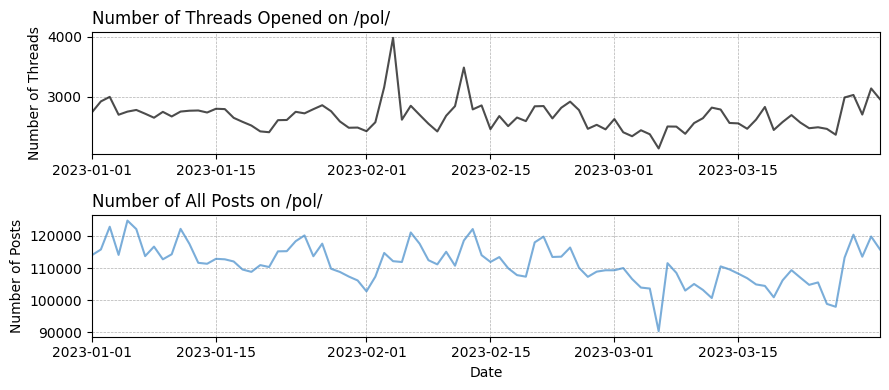

In [3]:
daily_posts = du.groupby(du['converted_timestamp'].dt.date).size().reset_index(name='total_posts')
daily_posts.columns = ['date', 'total_posts']  # Rename to ensure consistency
# Aggregate daily thread count
daily_threads = op.groupby(op['converted_timestamp'].dt.date)['thread_num'].count().reset_index()
daily_threads.columns = ['date', 'num_threads']
# Create subplot
fig, axes = plt.subplots(2, 1, figsize=(9, 4), sharex=True)
# Plot 1: Daily Thread Count (Top)
axes[0].plot(daily_threads['date'], daily_threads['num_threads'], linestyle='-', color='black', alpha=0.7)
axes[0].set_title("Number of Threads Opened on /pol/", loc='left')
axes[0].set_ylabel("Number of Threads")
axes[0].grid(True, linestyle="--", linewidth=0.5)
axes[0].tick_params(axis='x', which='both', labelbottom=True)
# Plot 2: Daily Post Count (Bottom) (FIXED: Using 'date' instead of 'converted_timestamp')
daily_posts = daily_posts[daily_posts['date'] != pd.to_datetime('2023-04-01').date()] # one april 1 snuck its way in 
axes[1].plot(daily_posts['date'], daily_posts['total_posts'], linestyle='-', color='#428bca', alpha=0.7)
axes[1].set_title("Number of All Posts on /pol/", loc='left')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Number of Posts")
axes[1].grid(True, linestyle="--", linewidth=0.5)
axes[0].set_xlim(daily_threads['date'].min(), daily_threads['date'].max())
axes[1].set_xlim(daily_posts['date'].min(), daily_posts['date'].max())
# Adjust layout
plt.tight_layout()
plt.show()

## /pol/ Thread Distribution
The distribution of the lifespan of threads (measured in amount of posts and the hours in which a thread remained active) tells us that the vast majority of threads do not spawn long conversations.

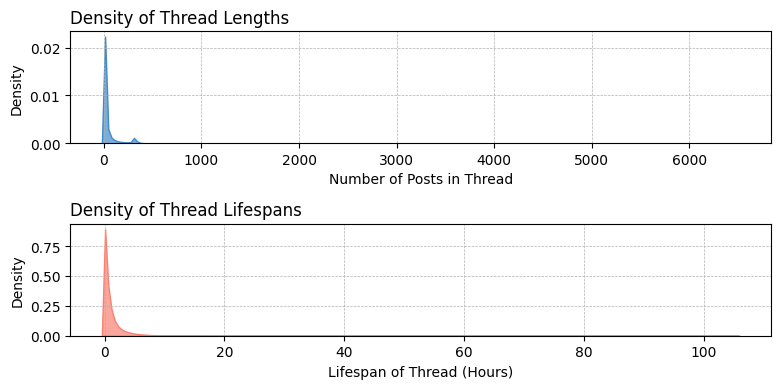

In [4]:
thread_lengths = op['post_count']
thread_lifespans = du.groupby('thread_num')['converted_timestamp'].agg(['min', 'max'])
thread_lifespans['lifespan_hours'] = (thread_lifespans['max'] - thread_lifespans['min']).dt.total_seconds() / 3600  # Convert to hours
# Create KDE plots
fig, axes = plt.subplots(2, 1, figsize=(8, 4))
# KDE for Thread Lengths
sns.kdeplot(thread_lengths, fill=True, color='#428bca', alpha=0.7, ax=axes[0])
axes[0].set_title("Density of Thread Lengths", loc='left')
axes[0].set_xlabel("Number of Posts in Thread")
axes[0].set_ylabel("Density")
axes[0].grid(True, linestyle="--", linewidth=0.5)
# KDE for Thread Lifespans
sns.kdeplot(thread_lifespans['lifespan_hours'], fill=True, color='salmon', alpha=0.7, ax=axes[1])
axes[1].set_title("Density of Thread Lifespans", loc='left')
axes[1].set_xlabel("Lifespan of Thread (Hours)")
axes[1].set_ylabel("Density")
axes[1].grid(True, linestyle="--", linewidth=0.5)
# Adjust layout
plt.tight_layout()
plt.show()

In [5]:
def df_to_thread_dict(df):
    thread_dict = {
        thread: thread_df.sort_values(by="timestamp")[["num", "comment"]].to_dict(orient='records')
        for thread, thread_df in df.groupby("thread_num")
    }
    return thread_dict

def precompute_thread_dict(df):
    thread_dict = {}
    for thread, thread_df in df.groupby("thread_num"):
        thread_dict[thread] = thread_df.sort_values(by="timestamp")[["num", "comment"]].to_dict(orient='records')
    return thread_dict

def pretokenize_comments(thread_dict):
    for thread, posts in thread_dict.items():
        for post in posts:
            post['tokenized_comment'] = set(post['comment'].lower().split())  # Store pre-tokenized words
    return thread_dict
karina = pretokenize_comments(precompute_thread_dict(du)) ### TURNING DATAFRAME INTO A DICTIONARY OF THREADS!!! 

In [6]:
def clean_word(word):
    return word.translate(str.maketrans('', '', string.punctuation))

def get_words_with_thread_range(thread_dict, min_threads=88, max_threads=None):
    word_thread_count = defaultdict(set)
    for thread_num, posts in thread_dict.items():
        for post in posts:
            words_in_post = {clean_word(word) for word in post['tokenized_comment'] if clean_word(word)}
            for word in words_in_post:
                word_thread_count[word].add(thread_num)
    if max_threads is not None:
        words_meeting_threshold = {word for word, threads in word_thread_count.items() if min_threads <= len(threads) <= max_threads}
    else:
        words_meeting_threshold = {word for word, threads in word_thread_count.items() if len(threads) >= min_threads}
    return words_meeting_threshold

def remove_word(word_list, word_to_remove):
    return [word for word in word_list if word != word_to_remove]

def filter_short_words(word_list):
    return [word for word in word_list if len(word) >= 3]

def filter_non_english_words(word_list):
    return [word for word in word_list if word.isascii() and word.isalpha() and len(word) >= 3]

with open("unrecwords.txt", "r") as file: 
    wisdom = [line.strip() for line in file]

wisdom = remove_word(wisdom, 'fvd')
wisdom = filter_short_words(wisdom)
wisdom = filter_non_english_words(wisdom)

with open("all_unrec_words.txt", "r") as file: 
    all_unrec_words = [line.strip() for line in file]

all_unrec_words_set = set(all_unrec_words)

words_filtered = get_words_with_thread_range(karina, min_threads=176, max_threads=71237)
socks = filter_short_words(words_filtered)
socks = filter_non_english_words(socks)

refilter = get_words_with_thread_range(karina, min_threads = 176)
ref = filter_short_words(refilter)
ref = filter_non_english_words(ref)
ball = [x for x in ref if x not in all_unrec_words] ### THIS IS THE LIST OF RECOGNIZED WORDS WITH NO THREAD CEILING 
feet = [x for x in socks if x not in all_unrec_words_set]  ### THIS IS THE LIST OF RECOGNIZED THREADS WITH THE CEILING!!! 

## Defined and Undefined Words

### Unrecognized Words  
- I found **849,609** unique "unrecognized" words using the spaCy large model to identify words in /pol/ posts that were not recognized as English.  
- I then filtered these words to include only those that appeared in **at least 176 unique threads**. Since there are 88 days between January 1 and March 31, this ensures that words were used at least twice per day on average. This returned **2,694 words**.   
- I then removed words with two characters or fewer, which resulted in **2,477 words**.  
- All the words in this list appeared in 176 < n < 71,237 unique threads. 

### Recognized Words  
- I collected all recognized words that appeared in at least 88 threads.   
- I created two lists for comparison with the unrecognized words:  
  - One that only included words that appeared in less than 71,237 threads (**17,791 words**). 
  - One that had no thread ceiling** (**17,877 words**). 
- **Rationale for thread ceilings:**  
  - We want to put our unrecognized words 'in context', so it makes sense to compare with words that appeared in the same frequency range. 
  - However, we also want to check to see if there's a larger pattern/structure governing word behavior by including more frequent words. 


# Tests  

To answer **"how do people use undefined words?"**, the first step seemed to me to be understand how people used words in general on /pol/.
To capture this, I examined how words distribute and persist across discussions by looking at:  

1. **Number of threads a word appeared in** (measuring spread across conversations)  
2. **Reappearance rate** (measuring persistence within a conversation)  
3. **Time entropy** (measuring unpredictability in appearance over time)  

---

## Number of Unique Threads  

The **Number of Unique Threads** measures how widely a word appears across different discussions. 

---

## Term Reappearance  

The **Reappearance Rate** measures how often a word appears again in a thread after its first mention, averaged across all threads where the word occurs.  

### **How is Reappearance Rate Calculated?**  

For a given word **w** across multiple threads, the reappearance rate is:  

$$
Reappearance\ Rate(w) = \frac{\sum \text{(Occurrences of } w \text{ after first mention)}}{\text{Number of unique threads where } w \text{ appears}}
$$  

- If a word appears only once in every thread it is used, its **reappearance rate** is **0**.  
- If a word frequently reappears after its first mention, its **reappearance rate** is **higher**.  

### **Example Calculation**  

Suppose a word appears in **3 different threads**, with the following counts:  

- **Thread 1**: Mentioned **once** (no reappearances).  
- **Thread 2**: Mentioned **5 times** (4 after the first).  
- **Thread 3**: Mentioned **3 times** (2 after the first).  

We calculate the **total occurrences after the first mention** across all threads:  

$$
4 + 2 + 0 = 6
$$  

Since the word appears in **3 unique threads**, the **Reappearance Rate** is:  

$$
\frac{6}{3} = 2.0
$$  

This means, on average, the word is repeated **2 additional times per thread** after its first mention.  

### **Normalization**  

Since words vary widely in how often they are used, we normalize the reappearance rate using Z-scores:  

$$
Normalized\ Reappearance\ Rate = \frac{Reappearance\ Rate - \mu}{\sigma}
$$  

Where:  
- \( \mu \) = Mean reappearance rate across all words  
- \( \sigma \) = Standard deviation of reappearance rates  
---

## Time Entropy  
**Time Entropy** measures how unpredictably a word appears across different days. A word with high entropy appears sporadically across time, while a word with low entropy appears in more stable, concentrated time periods.  

---

### **How is Time Entropy Calculated?**  

Given a word **w** that appears on multiple days, its probability distribution over time is:  

$$
P(w) = \frac{\text{Occurrences of } w \text{ on a given day}}{\text{Total occurrences of } w}
$$  

Then, **Time Entropy** is computed using Shannon entropy:  

$$
Time\ Entropy(w) = - \sum P(w) \log P(w)
$$  

- **Higher entropy** → The word appears unpredictably across many different days.  
- **Lower entropy** → The word appears in a concentrated, predictable time frame.  

---

### **Example Calculation**  

Suppose a word appears **10 times** in total, distributed across **5 days** as follows:  

| Date       | Occurrences |
|------------|------------|
| Day 1      | 5          |
| Day 2      | 2          |
| Day 3      | 2          |
| Day 4      | 1          |
| Day 5      | 0          |

#### **Step 1: Compute Probability Distribution**  
Each day’s probability of occurrence is:  

- \( P(w, Day\ 1) = \frac{5}{10} = 0.5 \)  
- \( P(w, Day\ 2) = \frac{2}{10} = 0.2 \)  
- \( P(w, Day\ 3) = \frac{2}{10} = 0.2 \)  
- \( P(w, Day\ 4) = \frac{1}{10} = 0.1 \)  
- \( P(w, Day\ 5) = \frac{0}{10} = 0.0 \) (ignored in entropy calculation)  

#### **Step 2: Compute Time Entropy**  

$$
Time\ Entropy(w) = - \left( 0.5 \log 0.5 + 0.2 \log 0.2 + 0.2 \log 0.2 + 0.1 \log 0.1 \right)
$$  

Approximating the logarithm values (base 2 or natural log can be used):  

$$
Time\ Entropy(w) \approx - \left( 0.5(-1) + 0.2(-2.32) + 0.2(-2.32) + 0.1(-3.32) \right)
$$  

$$
\approx - \left( -0.5 - 0.464 - 0.464 - 0.332 \right) = 1.76
$$  

- If the word appeared **only on one day**, its entropy would be **0** (fully predictable).  
- If it were perfectly evenly distributed across many days, its entropy would be **higher** (closer to maximum unpredictability).  

---

### **Normalization**  

#### **Z-score Normalization:**  
$$
Normalized\ Time\ Entropy = \frac{Time\ Entropy - \mu}{\sigma}
$$  

Where:  
- \( \mu \) = Mean time entropy across all words  
- \( \sigma \) = Standard deviation of time entropy  
---

## Additional Metrics Considered (But Not Used)  

I also tested other measures to explore word behavior:  

### **Threadwise Density**  

$$
Threadwise\ Density(w) = \frac{\text{Total occurrences of } w}{\text{Number of threads where } w \text{ appears}}
$$  

This measures how concentrated a word is within the threads it appears in. However, this was found to be **highly predictable** (**R² = 0.9 with thread count**) (I'm not sure if I should include it or what I should do with this)

### **Repeat Ratio**  

$$
Repeat\ Ratio(w) = \frac{\text{Occurrences of } w \text{ beyond the first mention}}{\text{Total occurrences of } w}
$$  

(Or this)

---

In [7]:
def compute_word_stickiness(thread_dict, word_list, df):
    word_list = set(word.lower() for word in word_list)
    word_tracking = {word: defaultdict(list) for word in word_list}
    word_thread_count = defaultdict(set)
    word_time_distribution = defaultdict(lambda: defaultdict(int))
    thread_date_lookup = df.set_index("thread_num")["converted_timestamp"].dt.date.to_dict()
    for thread_num, posts in thread_dict.items():
        first_mentions = {}
        thread_length = len(posts)
        thread_date = thread_date_lookup.get(thread_num, None)
        if thread_date is None:
            continue
        for idx, post in enumerate(posts):
            words_in_post = set(word.lower() for word in post['tokenized_comment'])
            for word in words_in_post & word_list:
                word_thread_count[word].add(thread_num)
                word_time_distribution[word][thread_date] += 1
                if word not in first_mentions:
                    first_mentions[word] = idx
                else:
                    word_tracking[word]['repeats'].append(idx - first_mentions[word]) 
        for word, first_idx in first_mentions.items():
            posts_after_first = thread_length - (first_idx + 1)
            repeats_after_first = len(word_tracking[word]['repeats'])
            if posts_after_first > 0:
                word_tracking[word]['survival_ratios'].append(repeats_after_first / posts_after_first)
    stickiness_data = []
    for word in tqdm(word_list, desc="Processing Words", unit="word"):
        repeats = sum(word_tracking[word]['repeats'])
        survival_ratios = word_tracking[word]['survival_ratios']
        unique_threads = len(word_thread_count[word])
        reappearance_rate = repeats / unique_threads if unique_threads > 0 else 0
        if not isinstance(survival_ratios, list):
            survival_ratios = [survival_ratios]
        if survival_ratios:
            threadwise_densities = [sum(ratios) / len(ratios) if isinstance(ratios, list) else ratios for ratios in survival_ratios]
            threadwise_density = np.median(threadwise_densities)
        else:
            threadwise_density = 0
        repeat_ratio = repeats / (len(word_tracking[word]['repeats']) + 1) if repeats > 0 else 0
        if word_time_distribution[word]:
            time_spread = max(word_time_distribution[word].keys()) - min(word_time_distribution[word].keys())
            time_stickiness = repeats / time_spread.days if time_spread.days > 0 else 0
        else:
            time_stickiness = 0
        day_counts = list(word_time_distribution[word].values())
        prob_distribution = np.array(day_counts) / sum(day_counts) if sum(day_counts) > 0 else []
        time_entropy = entropy(prob_distribution) if len(prob_distribution) > 1 else 0
        stickiness_data.append((word, unique_threads, reappearance_rate, threadwise_density, repeat_ratio, time_stickiness, time_entropy))
    stickiness_df = pd.DataFrame(stickiness_data, columns=["word", "unique_threads", "reappearance_rate", "threadwise_density", "repeat_ratio", "time_stickiness", "time_entropy"])
    for col in ["unique_threads", "reappearance_rate", "threadwise_density", "repeat_ratio", "time_stickiness", "time_entropy"]:
        mean_val = stickiness_df[col].mean()
        std_val = stickiness_df[col].std()
        min_val = stickiness_df[col].min()
        max_val = stickiness_df[col].max()
        stickiness_df[f"normalized_{col}_zscore"] = (stickiness_df[col] - mean_val) / std_val
        stickiness_df[f"normalized_{col}_minmax"] = (stickiness_df[col] - min_val) / (max_val - min_val) if max_val > min_val else 0
    return stickiness_df

In [8]:
# GETTING DATA ABOUT WORD BEHAVIOR 
gecko = compute_word_stickiness(karina, wisdom, du)
gecko = gecko[gecko['unique_threads'] > 176]
# RECOGNIZED WORDS WITH CEILING 
the_known_words = compute_word_stickiness(karina, feet, du)
the_known_words = the_known_words.dropna()
the_known_words = the_known_words[the_known_words['unique_threads'] > 176]
#len(the_known_words)
# RECOGNIZED WORDS WITHOUT CEILING 
bigger_known_words = compute_word_stickiness(karina, ball, du)
bigger_known_words = bigger_known_words.dropna()
bigger_known_words = bigger_known_words[bigger_known_words['unique_threads'] > 176]
#len(bigger_known_words)

Processing Words: 100%|██████████| 20017/20017 [00:05<00:00, 3356.93word/s]


## Characterizing Defined Word Behavior (and how undefined words fit into trends)
### Findings
Unrecognized words followed the expected trend and did not behave unexpectedly. However, among recognized words, some deviated from the main polynomial trend. I hypothesized that these outliers were topic-specific—appearing due to major events rather than being evenly distributed over time.

Since we filtered for words that appeared in at least 88 unique threads, ensuring a baseline level of activity, there was no reason to assume that words with higher reappearance rates would be concentrated in a specific period. However, I found that words with lower entropy—those less evenly spread across the timeframe—also tended to have higher-than-expected reappearance rates, supporting the idea that temporal concentration plays a role in reappearance behavior.

By comparing unrecognized words to this pattern, I found that most fell into the category of "bursty" event-specific words, but interestingly, a few followed the general trend. This included some recognized English words— I haven't the foggiest idea why the spaCy model failed to classify them as such (the words are more 'sensitive' like 'hate' and 'jews')

Polynomial Equation: y = 0.0477x² + 0.1800x + -0.0393


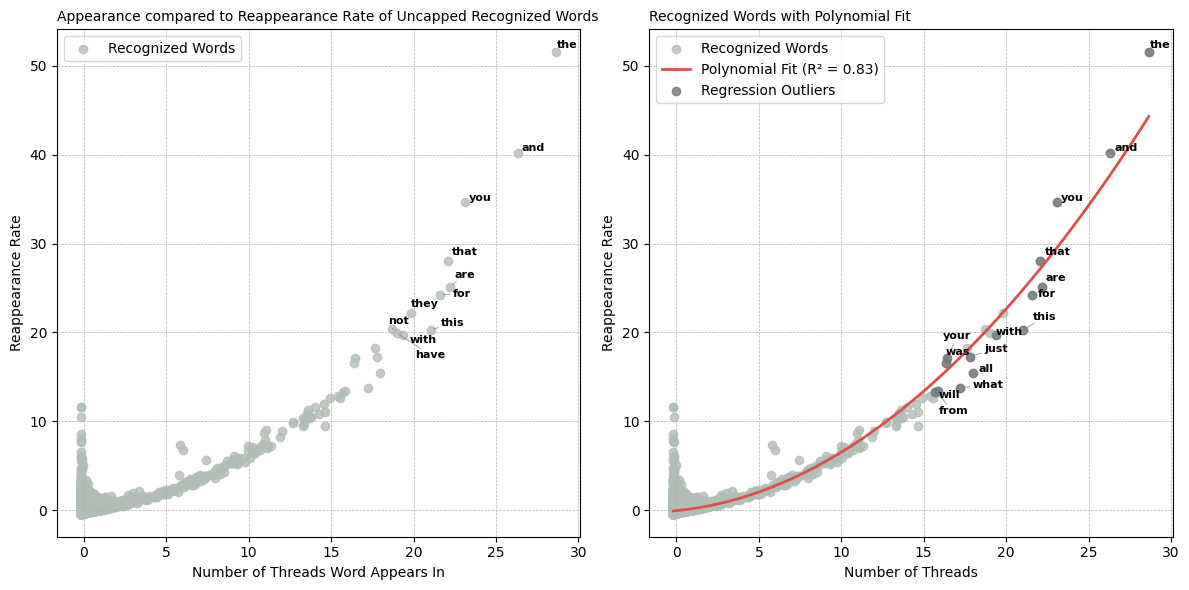

In [26]:
def big_thread_appear_poly(known_political_words, 
                           x_col='normalized_unique_threads_zscore', 
                           y_col='normalized_reappearance_rate_zscore'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Scatter plot of recognized words (Left Plot)
    axes[0].scatter(known_political_words[x_col], known_political_words[y_col], 
                    color='#B2BEB5', alpha=0.8, label="Recognized Words")  
    # Annotate top words
    top_reappear = known_political_words.nlargest(10, y_col)
    top_spread = known_political_words.nlargest(10, x_col)
    top_words = pd.concat([top_reappear, top_spread]).drop_duplicates(subset=['word'])
    text_objects = []
    for _, row in top_words.iterrows():
        text_objects.append(axes[0].annotate(row['word'], 
                                             (row[x_col], row[y_col]), 
                                             fontsize=8, color='black', weight='bold'))
    adjust_text(text_objects, ax=axes[0], arrowprops=dict(arrowstyle="-", color="gray", lw=0.5)) 
    axes[0].set_xlabel("Number of Threads Word Appears In")
    axes[0].set_ylabel("Reappearance Rate")
    axes[0].set_title("Appearance compared to Reappearance Rate of Uncapped Recognized Words", loc='left', fontsize=10)
    axes[0].legend()
    axes[0].grid(True, linestyle="--", linewidth=0.5)
    # Scatter plot with Polynomial Regression overlay (Right Plot)
    X = known_political_words[[x_col]].values.reshape(-1, 1)
    y = known_political_words[y_col].values
    poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    poly_model.fit(X, y)
    # Extract polynomial coefficients
    poly_coeffs = poly_model.named_steps['linearregression'].coef_
    intercept = poly_model.named_steps['linearregression'].intercept_
    # Print the polynomial equation
    print(f"Polynomial Equation: y = {poly_coeffs[2]:.4f}x² + {poly_coeffs[1]:.4f}x + {intercept:.4f}")
    # Generate regression curve
    X_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)  
    y_pred_poly = poly_model.predict(X_range)
    r2 = r2_score(y, poly_model.predict(X))  # Compute R² for polynomial regression
    axes[1].scatter(known_political_words[x_col], known_political_words[y_col], 
                    color='#B2BEB5', alpha=0.8, label="Recognized Words")
    axes[1].plot(X_range, y_pred_poly, color='#da4f4a', linewidth=2, 
                 label=f'Polynomial Fit (R² = {r2:.2f})')
    # Identify outliers based on regression residuals
    residuals = np.abs(y - poly_model.predict(X))
    residual_threshold = np.percentile(residuals, 96)  # Higher threshold (96th percentile) for stricter outlier detection
    regression_outliers = known_political_words[residuals > residual_threshold]
    regression_outliers = regression_outliers.nlargest(15, y_col)  # Keep only top 15 outliers
    axes[1].scatter(regression_outliers[x_col], regression_outliers[y_col], color='#71797E', alpha=0.8, label="Regression Outliers")
    # Annotate top 15 outliers
    text_objects = []
    for _, row in regression_outliers.iterrows():
        text_objects.append(axes[1].annotate(row['word'], 
                                             (row[x_col], row[y_col]), 
                                             fontsize=8, color='black', weight='bold'))
    adjust_text(text_objects, ax=axes[1], arrowprops=dict(arrowstyle="-", color="gray", lw=0.5))
    axes[1].set_xlabel("Number of Threads")
    axes[1].set_ylabel("Reappearance Rate")
    axes[1].set_title("Recognized Words with Polynomial Fit", loc='left', fontsize=10)
    axes[1].legend()
    axes[1].grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()
big_thread_appear_poly(bigger_known_words)

### Most recognized words follow a predictable pattern
We expect that more common words -- words that appear in more threads -- to also reappear more, as they are likely more essential/ relevant words in conversation. This expectation is **largely supported by the data**—the correlation between thread count and reappearance rate is strong (\( R^2 = 0.75 \)). However, **this relationship is not universal**, indicated by clear deviations near threads that appear less, but have a higher reappearance rate than predicted. Further, the correlation matrix tells us that this relationship is significantly weakened when we exclude words that appear most frequently in unique threads. To understand this, I used our set of words that exclude words that appeared in more than 71,237 threads to look at the distribution. 

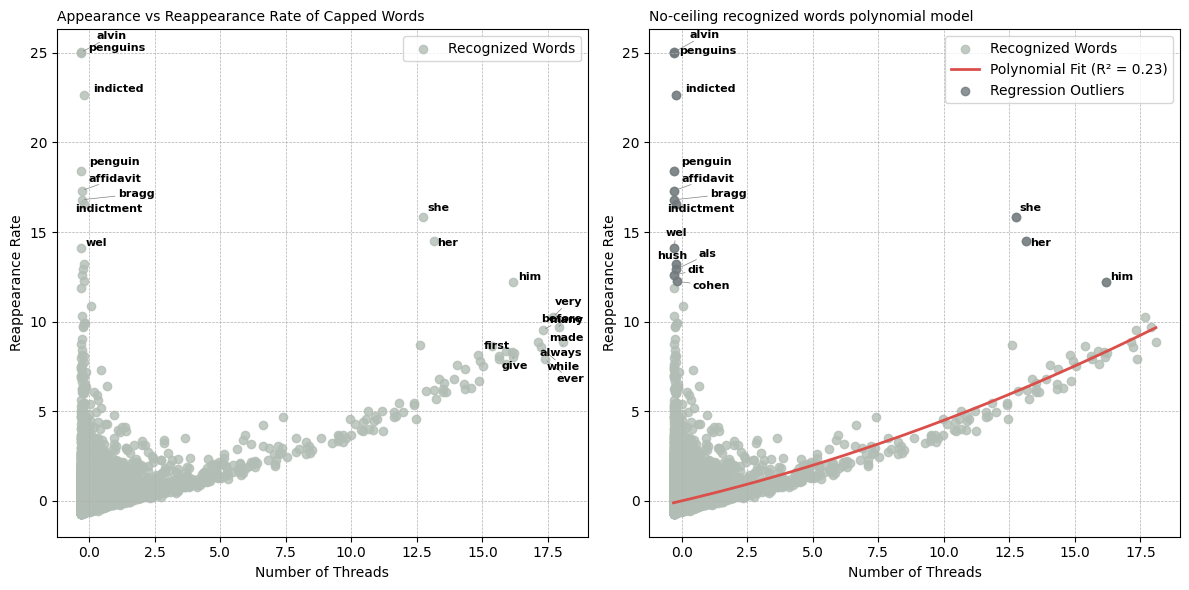

In [25]:
def thread_appear_poly(known_political_words, x_col='normalized_unique_threads_zscore', y_col='normalized_reappearance_rate_zscore'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Scatter plot of recognized words (Left Plot)
    axes[0].scatter(known_political_words[x_col], known_political_words[y_col], 
                    color='#B2BEB5', alpha=0.8, label="Recognized Words")  
    # Annotate top words
    top_reappear = known_political_words.nlargest(10, y_col)
    top_spread = known_political_words.nlargest(10, x_col)
    top_words = pd.concat([top_reappear, top_spread]).drop_duplicates(subset=['word'])
    text_objects = []
    for _, row in top_words.iterrows():
        text_objects.append(axes[0].annotate(row['word'], 
                                             (row[x_col], row[y_col]), 
                                             fontsize=8, color='black', weight='bold'))
    adjust_text(text_objects, ax=axes[0], arrowprops=dict(arrowstyle="-", color="gray", lw=0.5)) 
    axes[0].set_xlabel("Number of Threads")
    axes[0].set_ylabel("Reappearance Rate")
    axes[0].set_title("Appearance vs Reappearance Rate of Capped Words", loc='left', fontsize=10)
    axes[0].legend()
    axes[0].grid(True, linestyle="--", linewidth=0.5)
    # Scatter plot with Polynomial Regression overlay (Right Plot)
    X = known_political_words[[x_col]].values.reshape(-1, 1)
    y = known_political_words[y_col].values
    poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    poly_model.fit(X, y)
    X_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)  # Ensure smooth curve
    y_pred_poly = poly_model.predict(X_range)
    r2 = r2_score(y, poly_model.predict(X))  # Compute R² for polynomial regression
    axes[1].scatter(known_political_words[x_col], known_political_words[y_col], 
                    color='#B2BEB5', alpha=0.8, label="Recognized Words")
    axes[1].plot(X_range, y_pred_poly, color='#da4f4a', linewidth=2, 
                 label=f'Polynomial Fit (R² = {r2:.2f})')
    # Identify outliers based on regression residuals
    residuals = np.abs(y - poly_model.predict(X))
    residual_threshold = np.percentile(residuals, 96)  # Higher threshold (98th percentile) for stricter outlier detection
    regression_outliers = known_political_words[residuals > residual_threshold]
    regression_outliers = regression_outliers.nlargest(15, y_col)  # Keep only top 15 outliers
    axes[1].scatter(regression_outliers[x_col], regression_outliers[y_col], color='#71797E', alpha=0.8, label="Regression Outliers")
    # Annotate top 15 outliers
    text_objects = []
    for _, row in regression_outliers.iterrows():
        text_objects.append(axes[1].annotate(row['word'], 
                                             (row[x_col], row[y_col]), 
                                             fontsize=8, color='black', weight='bold'))
    adjust_text(text_objects, ax=axes[1], arrowprops=dict(arrowstyle="-", color="gray", lw=0.5))
    axes[1].set_xlabel("Number of Threads")
    axes[1].set_ylabel("Reappearance Rate")
    axes[1].set_title("No-ceiling recognized words polynomial model", loc='left', fontsize=10)
    axes[1].legend()
    axes[1].grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()
thread_appear_poly(the_known_words)

### Model Performance Decreases at Finer Granularity
When analyzing the entire dataset, including ubiquitous words, there is a strong relationship between the number of threads and a word’s reappearance score. However, when restricting the analysis to the frequency range in which unrecognized words occur, the broader pattern observed in the larger dataset remains visually present but is significantly weakened. Instead, we observe a secondary pattern—or in some cases, a lack of one—where words appearing in many threads tend to reappear frequently, but without a clear structure.  

### Interpreting Words That Reappear More Than Expected
A possible explanation is that these words are event-specific and emerge due to contextual relevance rather than general linguistic frequency. This hypothesis can be tested by examining whether:  
- Words deviating from the polynomial trend (i.e., those concentrated near the y-axis) exhibit lower time entropy, meaning their occurrences are temporally clustered.  

### Relationship Between Time Entropy and Deviation from Expected Patterns  
The scatter plot, where time entropy is encoded as color, indicates that words following the expected thread appearance/reappearance trend are evenly distributed across time (entropy ≈ 1). In contrast, words that deviate from this trend tend to have lower time entropy, meaning they appear in distinct episodes rather than being evenly spread throughout the timeframe.  


In [49]:
def plot_and_quantify_relationship(df, 
                                   x_col='normalized_unique_threads_zscore', 
                                   y_col='normalized_reappearance_rate_zscore', 
                                   color_col='normalized_time_entropy_zscore'):
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values.reshape(-1, 1)
    z = df[color_col].values.reshape(-1, 1)

    mask = df[color_col] != 1
    color_min, color_max = -5, 1  # Explicitly setting the range from -5 to 1

    fig, ax = plt.subplots(figsize=(10, 6))

    # **Scatter plot with color gradient for time entropy**
    scatter = ax.scatter(df[x_col][mask], df[y_col][mask], c=df[color_col][mask], 
                         cmap='coolwarm', alpha=0.9, s=50, vmin=color_min, vmax=color_max)
    ax.scatter(df[x_col][~mask], df[y_col][~mask], c='red', alpha=0.5, s=50)

    # **Colorbar**
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Time Entropy (Red = 1, Blue = -5)")
    cbar.set_ticks(np.linspace(-5, 1, num=7))  # Explicit tick marks from -5 to 1

    ax.set_xlabel("Normalized Unique Threads Z-Score", fontsize=9)
    ax.set_ylabel("Normalized Reappearance Rate Z-Score", fontsize=9)
    ax.set_title("Threads vs. Reappearance Rate with Time Entropy", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.5)

    # **STATISTICAL TESTS**
    residuals = np.abs(y.flatten() - np.polyval(np.polyfit(x.flatten(), y.flatten(), 2), x.flatten()))

    # Correlations
    spearman_corr, spearman_p = spearmanr(df[color_col], residuals)
    pearson_corr, pearson_p = pearsonr(df[color_col], residuals)

    # Regression
    X = sm.add_constant(df[color_col])  # Independent variable (Time Entropy)
    model = sm.OLS(residuals, X).fit()
    regression_coef = model.params[color_col]
    regression_p = model.pvalues[color_col]

    # Mann-Whitney U test
    median_residual = np.median(residuals)
    low_dev = df[df[color_col] <= median_residual][color_col]
    high_dev = df[df[color_col] > median_residual][color_col]
    mann_u, mann_p = mannwhitneyu(low_dev, high_dev, alternative='less')

    # **Create a stats table**
    stat_results = pd.DataFrame({
        "Test": ["Spearman Correlation", "Pearson Correlation", "Regression Coefficient", "Mann-Whitney U"],
        "Value": [spearman_corr, pearson_corr, regression_coef, mann_u],
        "p-Value": [spearman_p, pearson_p, regression_p, mann_p]
    })

    # **Show the plot**
    plt.show()

    # **Return the labeled stats table for Quarto to render below the plot**
    print("### Significance Tests of Time Entropy")
    return stat_results

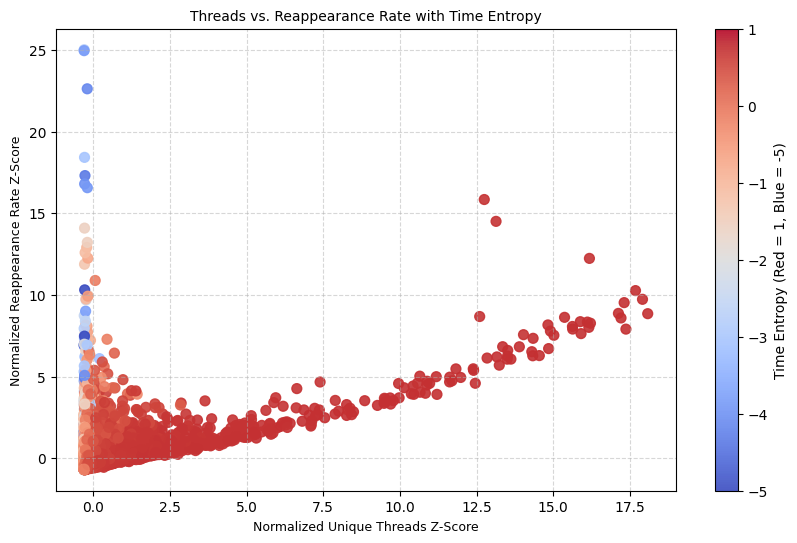

### Significance Tests of Time Entropy


,Test,Value,p-Value
0,Spearman Correlation,-0.140192,1.269445e-77
1,Pearson Correlation,-0.366995,0.000000e+00
2,Regression Coefficient,-0.551468,0.000000e+00
3,Mann-Whitney U,0.000000,0.000000e+00


In [50]:
plot_and_quantify_relationship(the_known_words)

### Episodic Words 
The scatter timeline visualizes the 30 least entropic words, highlighting when they appeared and the distinct peaks of their activity, making their temporal clustering more apparent. You can see how some words are linked to events (like 'valentines'; the Chinese weather balloon incident also happened in early Februrary 2023).

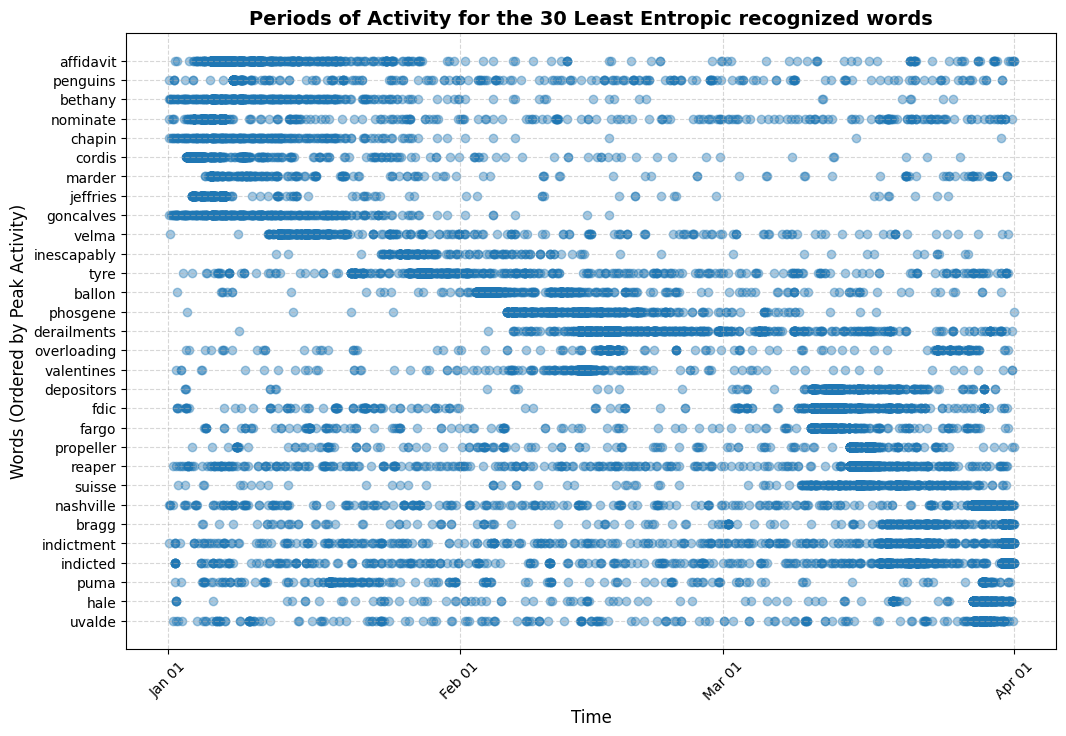

In [ ]:
top_50_entropic_words = (
    the_known_words.nsmallest(30, 'normalized_time_entropy_zscore')
)
top_50_entropic_words = [x for x in top_50_entropic_words['word']]
entropic_words_set = set(top_50_entropic_words)
dh = du.set_index("num")
post_date_lookup = dh['converted_timestamp'].to_dict() 
filtered_karina = {
    thread_id: [post for post in posts if post["tokenized_comment"] & entropic_words_set]
    for thread_id, posts in karina.items()
}
word_data = {word: {"dates": [], "gaps": []} for word in entropic_words_set}
for thread_id, posts in filtered_karina.items():
    for post in posts:
        post_id = post["num"]
        post_date = post_date_lookup.get(post_id)
        if post_date is None:
            continue  # Skip if no date found
        words_in_post = post["tokenized_comment"] & entropic_words_set  # Fast set intersection
        for word in words_in_post:
            word_data[word]["dates"].append(post_date)
for word, data in word_data.items():
    if data["dates"]:  # Only process if we have dates
        data["dates"].sort()
        if len(data["dates"]) > 1:
            data["gaps"] = np.diff(data["dates"]).tolist()
word_occurrences = []
for word, data in word_data.items():
    for date in data["dates"]:
        word_occurrences.append({"word": word, "date": date})
df_words = pd.DataFrame(word_occurrences)
# Ensure date is in datetime format
df_words["date"] = pd.to_datetime(df_words["date"]) # BRUH 
# Convert to weekly bins
df_words["week"] = df_words["date"].dt.to_period("W")
# === Step 2: Find Each Word's Peak Activity Period ===
weekly_counts = df_words.groupby(["word", "week"]).size().reset_index(name="count")
# Find the week with the highest occurrence for each word
peak_weeks = weekly_counts.loc[weekly_counts.groupby("word")["count"].idxmax(), ["word", "week"]]
# Convert week to start date for sorting
peak_weeks["week_start"] = peak_weeks["week"].apply(lambda x: x.start_time)
# Sort words by earliest peak week
sorted_words = peak_weeks.sort_values("week_start")["word"].tolist()
sorted_words.reverse() 
word_to_ypos = {word: i for i, word in enumerate(sorted_words)}  # Assign rank-based index
# Replace words in df_words with their Y-position
df_words["y_pos"] = df_words["word"].map(word_to_ypos)
# === Step 4: Plot Scatter Timeline with Ordered Y-Axis ===
plt.figure(figsize=(12, 8))
plt.scatter(df_words["date"], df_words["y_pos"], alpha=0.4, marker='o')
# Formatting
plt.xlabel("Time", fontsize=12)
plt.ylabel("Words (Ordered by Peak Activity)", fontsize=12)
plt.title("Periods of Activity for the 30 Least Entropic Recognized words", fontsize=10, fontweight="bold")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
# Format date axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks at months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as "Jan 01"
# Replace Y-axis tick labels with word names in correct order
plt.yticks(ticks=list(word_to_ypos.values()), labels=sorted_words)
# Show plot
plt.show()

In [14]:
def compare_thread_reappear(gecko, known_political_words, x_col='unique_threads', y_col='normalized_reappearance_rate_zscore'):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # Left plot: ONLY Unrecognized words
    axes[0].scatter(gecko[x_col], gecko[y_col], color='#428bca', alpha=0.6, label="Unrecognized Words")  # Blue dots only
    axes[0].set_xlabel("Number of Threads Word Appears In")
    axes[0].set_ylabel("Normalized Reappearance Rate (Z-Score)")
    axes[0].set_title("Frequency with which unrecognized words appear", loc='left')
    # Annotate top unrecognized words (based on Y and X values)
    top_gecko_reappear = gecko.nlargest(8, y_col)
    top_gecko_spread = gecko.nlargest(8, x_col)
    top_gecko_words = pd.concat([top_gecko_reappear, top_gecko_spread]).drop_duplicates(subset=['word'])
    for _, row in top_gecko_words.iterrows():
        text = axes[0].annotate(row['word'], 
                                (row[x_col], row[y_col] + 0.1),  
                                fontsize=8, color='black', ha='center', weight='bold')
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground="white"), path_effects.Normal()])
    axes[0].grid(True, linestyle="--", linewidth=0.5)
    ### Capture axis limits from the first plot BEFORE creating the second plot
    x_limits = axes[0].get_xlim()
    y_limits = axes[0].get_ylim()
    # Right plot: Recognized words FIRST, then overlay Unrecognized words
    axes[1].scatter(known_political_words[x_col], known_political_words[y_col], color='#B2BEB5', alpha=0.6, label="Recognized Words")  # Grey dots (background)
    axes[1].scatter(gecko[x_col], gecko[y_col], color='#428bca', alpha=0.6, label="Unrecognized Words")  # Blue dots (foreground)
    # Polynomial regression model for recognized words
    X = known_political_words[[x_col]].values.reshape(-1, 1)
    y = known_political_words[y_col].values
    poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    poly_model.fit(X, y)
    X_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    y_pred_poly = poly_model.predict(X_range)
    r2 = r2_score(y, poly_model.predict(X))
    axes[1].plot(X_range, y_pred_poly, color='#da4f4a', linewidth=2, label=f'Polynomial Fit (R² = {r2:.2f})')
    # Apply the same axis limits from the first plot
    axes[1].set_xlim(x_limits)
    axes[1].set_ylim(y_limits)
    # Label top 5 recognized words with highest X and Y values
    top_recognized_x = known_political_words.nlargest(5, x_col)
    top_recognized_y = known_political_words.nlargest(5, y_col)
    top_recognized_words = pd.concat([top_recognized_x, top_recognized_y]).drop_duplicates(subset=['word'])
    for _, row in top_recognized_words.iterrows():
        text = axes[1].annotate(row['word'], 
                                (row[x_col], row[y_col] + 0.1),  
                                fontsize=8, color='#B2BEB5', ha='center', weight='bold')  # Match dot color
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground="white"), path_effects.Normal()])
    # Set labels, title, and legend
    axes[1].set_xlabel("Number of Threads Word Appears In")
    axes[1].set_ylabel("Normalized Reappearance Rate (Z-Score)")
    axes[1].set_title("Frequency with which unrecognized and recognized words appear", loc='left')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

### **Unrecognized Words Align with Recognized Word Thread / Reappearance Rate Relationship**  
- A comparison of distributions shows that unrecognized words follow the same patterns observed in recognized words. Specifically, they align with two distinct trends:  
  1) Some words conform to the general model.  
  2) Other words appear in relatively few unique threads but exhibit high reappearance rates.  
- There is no clear evidence that unrecognized words form a distinct pattern separate from these existing trends.  

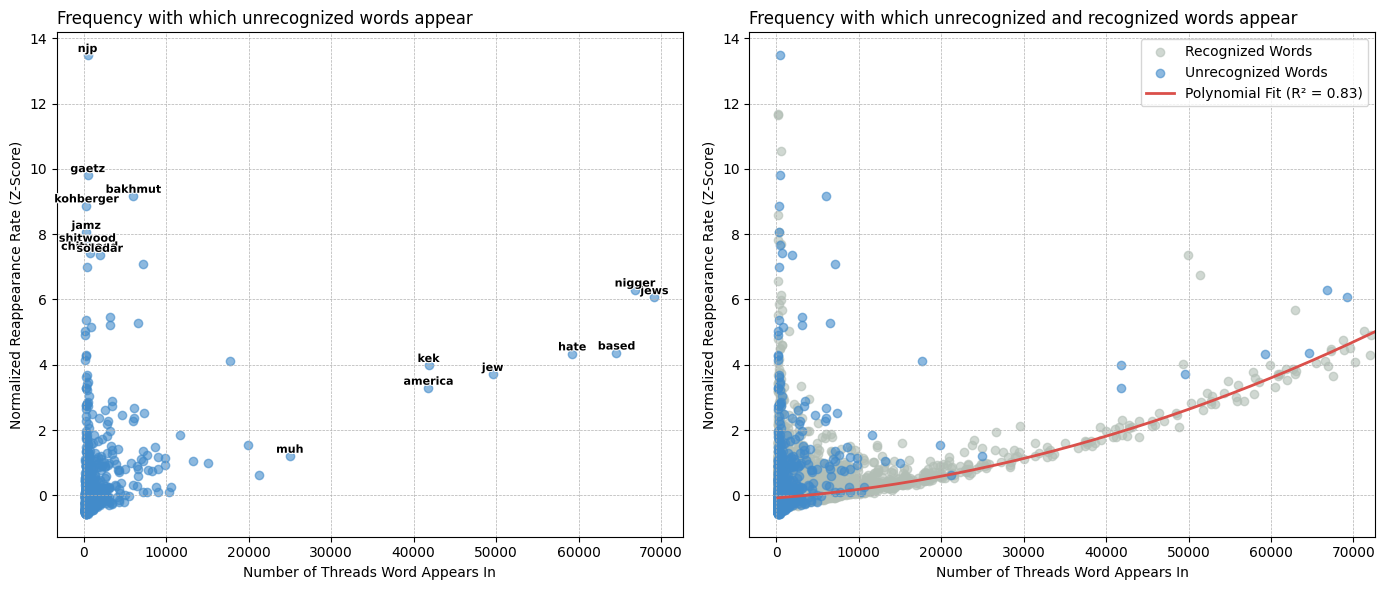

In [15]:
compare_thread_reappear(gecko, bigger_known_words)

### **Unrecognized Words Also Align with Recognized Word Time Entropy Relationship**  

For unrecognized words, those with **high reappearance rates but low thread appearance rates** also tend to have **lower time entropy**, meaning their occurrences are more concentrated within specific periods. This pattern is consistent with what we observe in recognized words.  

#### **Word Counts by Time Entropy**  
| Category            | Low Entropy (Time-Concentrated) | High Entropy (Evenly Distributed) |
|--------------------|--------------------------------|----------------------------------|
| **Unrecognized Words** | 430                            | 1,511                            |
| **Recognized Words**   | 7,638                          | 17,690                           |

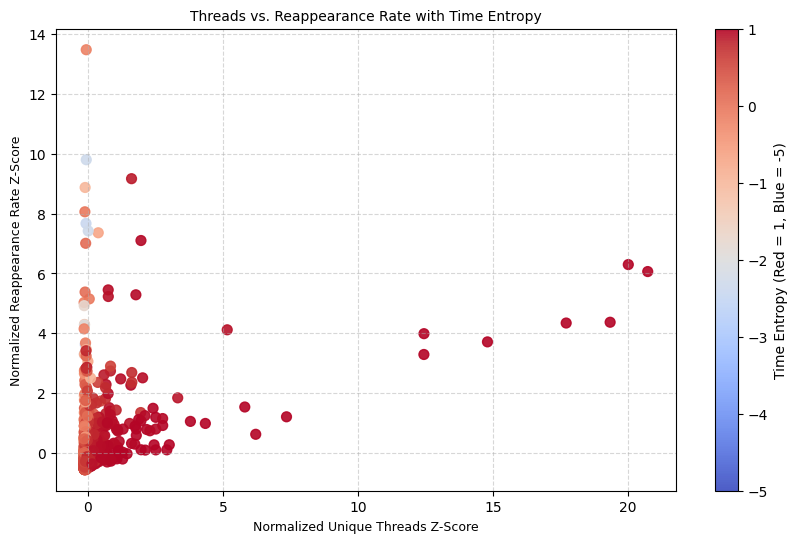

### Significance Tests of Time Entropy


,Test,Value,p-Value
0,Spearman Correlation,0.062371,4.740710e-02
1,Pearson Correlation,-0.419356,2.499583e-44
2,Regression Coefficient,-1.010307,2.499583e-44
3,Mann-Whitney U,0.000000,1.632949e-111


In [51]:
plot_and_quantify_relationship(gecko)

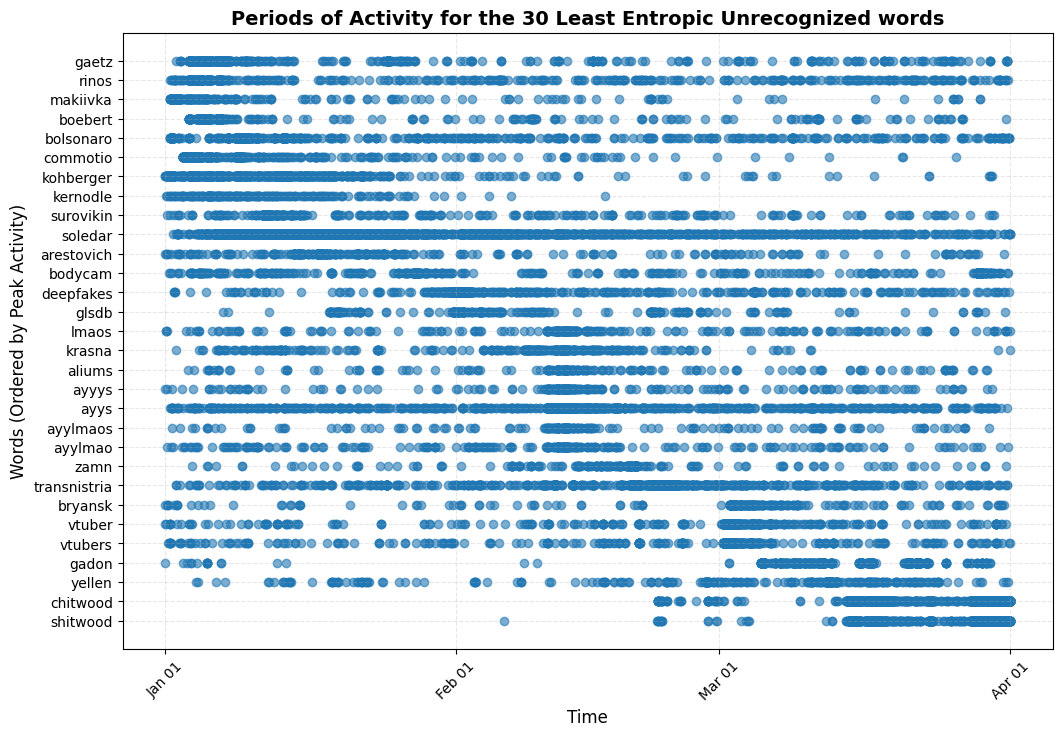

In [29]:
top_50_entropic_words = (
    gecko.nsmallest(30, 'normalized_time_entropy_zscore')
)
top_50_entropic_words = [x for x in top_50_entropic_words['word']]
entropic_words_set = set(top_50_entropic_words)
dh = du.set_index("num")
post_date_lookup = dh['converted_timestamp'].to_dict() 
filtered_karina = {
    thread_id: [post for post in posts if post["tokenized_comment"] & entropic_words_set]
    for thread_id, posts in karina.items()
}
word_data = {word: {"dates": [], "gaps": []} for word in entropic_words_set}
for thread_id, posts in filtered_karina.items():
    for post in posts:
        post_id = post["num"]
        post_date = post_date_lookup.get(post_id)
        if post_date is None:
            continue  # Skip if no date found
        words_in_post = post["tokenized_comment"] & entropic_words_set  # Fast set intersection
        for word in words_in_post:
            word_data[word]["dates"].append(post_date)
for word, data in word_data.items():
    if data["dates"]:  # Only process if we have dates
        data["dates"].sort()
        if len(data["dates"]) > 1:
            data["gaps"] = np.diff(data["dates"]).tolist()
word_occurrences = []
for word, data in word_data.items():
    for date in data["dates"]:
        word_occurrences.append({"word": word, "date": date})
df_words = pd.DataFrame(word_occurrences)
# Ensure date is in datetime format
df_words["date"] = pd.to_datetime(df_words["date"])
# Convert to weekly bins
df_words["week"] = df_words["date"].dt.to_period("W")
# === Step 2: Find Each Word's Peak Activity Period ===
weekly_counts = df_words.groupby(["word", "week"]).size().reset_index(name="count")
# Find the week with the highest occurrence for each word
peak_weeks = weekly_counts.loc[weekly_counts.groupby("word")["count"].idxmax(), ["word", "week"]]
# Convert week to start date for sorting
peak_weeks["week_start"] = peak_weeks["week"].apply(lambda x: x.start_time)
# Sort words by earliest peak week
sorted_words = peak_weeks.sort_values("week_start")["word"].tolist()
sorted_words.reverse() 
# === Step 3: Create a Mapping for Y-axis Positions ===
word_to_ypos = {word: i for i, word in enumerate(sorted_words)}  # Assign rank-based index
# Replace words in df_words with their Y-position
df_words["y_pos"] = df_words["word"].map(word_to_ypos)
# === Step 4: Plot Scatter Timeline with Ordered Y-Axis ===
plt.figure(figsize=(12, 8))
plt.scatter(df_words["date"], df_words["y_pos"], alpha=0.6, marker='o')
# Formatting
plt.xlabel("Time", fontsize=12)
plt.ylabel("Words (Ordered by Peak Activity)", fontsize=12)
plt.title("Periods of Activity for the 30 Least Entropic Unrecognized words", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.3)
# Format date axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks at months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as "Jan 01"
# Replace Y-axis tick labels with word names in correct order
plt.yticks(ticks=list(word_to_ypos.values()), labels=sorted_words)
# Show plot
plt.show()

## Approximating Semantic Cohesion  

### Takeaways from Appearance, Reappearance, and Time Entropy  
Words generally reappear in **predictable patterns**, except for those that consistently do not. These words appear to be **topic-specific**, as they occur frequently within a limited number of threads but are not widely distributed across discussions. This hypothesis was confirmed by observing that words deviating from the expected reappearance pattern also exhibit **low time entropy**, meaning they are concentrated within specific time periods. Notably, unrecognized words follow the same trend, reinforcing the predictability of their behavior within discussions.  

## 'Fictitious Prediction' Task  

### Objective  
This task examines whether the function of a word can be inferred from its usage and whether our analysis of word behavior can generate a working definition. This is not a true prediction task, as we generally know the meaning of most words. Instances where individuals use words without understanding their meaning in good faith are rare and often atypical in linguistic intent. However, this approach allows us to later **reverse-engineer** word meanings for unknown terms.  

### Dataset and Filtering  
The dataset consists of all posts from `/pol/` in January 2023. The filtering process includes:  
- Retaining only posts containing **target_word**.  
- Splitting posts into sentences and selecting only those where **target_word** appears.  
- Duplicating sentences when **target_word** appears multiple times within the same sentence.  
- Constructing a dataset that exclusively contains individual **target_word** sentence contexts.  

### Masking and Prediction Process  
The target word is replaced with a special `<mask>` token. For example:  

- Original: *"Keep talking, nobody’s listening."*  
- Masked: *"Keep `<mask>`, nobody’s listening."*  

Using the RoBERTa language model, the masked token is predicted based on its surrounding context. However, predicting a word from a **single sentence** is often ambiguous, even for humans. For example, in *"I’m a `<mask>`"*, the masked word could belong to numerous grammatical categories. Nonetheless, sentence context imposes constraints on the possible values for `<mask>`, helping to infer its function.  

### Accumulating Meaning Across Sentences  
With multiple sentence contexts, RoBERTa can refine its predictions incrementally, for example: 

1. *"My sister is a `<mask>` of literature at Stanford University."*  
2. *"He’s a terrible `<mask>`, all he thinks about is playing Genshin Impact instead of paying attention in class."*  
3. *"How many `<mask>`s do you have to teach?"*  

Initially, RoBERTa assigns probabilities to various candidate words. With each additional sentence, it updates these probabilities based on new contextual evidence. This allows the model to refine its understanding of `<mask>`, accumulating meaning over time.  

## Applying Bayesian Updating for Meaning Accumulation  

Using Bayes’ theorem, the probability of a word given new evidence is:  

\[
P(\text{word} | \text{evidence}) = \frac{P(\text{evidence} | \text{word}) P(\text{word})}{P(\text{evidence})}
\]

However, since each probability value is less than 1, multiplying successive probabilities results in **progressive dilution**, disproportionately penalizing frequent words. A word with an initial probability of **0.95** may see its likelihood decrease exponentially as it appears more frequently:  

\[
0.95^n
\]

Conversely, a word appearing only once with a **0.1** probability would dominate under this approach.  

###  Log-Probability Space  
To prevent probability dilution, we convert to **log-space**, allowing accumulation via addition rather than multiplication:  

\[
\log P(\text{word} | \text{evidence}) = \log P(\text{evidence} | \text{word}) + \log P(\text{word}) - \log P(\text{evidence})
\]

This transformation ensures a **more stable accumulation of evidence** over successive sentence contexts. The model processes sentences **sequentially**, meaning we can observe how its interpretation of `<mask>` evolves over time. Moreover, if RoBERTa predicts **synonyms** of `<mask>`, it suggests that the word's **semantic function** has been accurately recovered.  

## Samples and Trials 

Link to code here => 
The results below generated using **five trials**, with each trial consisting of **20 randomly sampled sentence instances** of a given word. This number was chosen based on the following considerations but this can be iterated on (I did try many other variations)

- RoBERTa already biases toward **common words**, as it has encountered them more frequently.  
- Even if common words initially have **lower confidence scores**, their frequent reappearance may artificially elevate their likelihood.  
- The probability of requiring more than **50 sentence contexts** for a reasonable inference is low.  
- In theory, a **perfect model** should improve its representation of a word as additional contexts are provided.  


## Measures 

# Candidate Distribution Metrics  

Each word has a **candidate probability distribution**—a set of words predicted by RoBERTa as replacements for `<mask>`, with associated probabilities. 

---

## 1. Cosine Similarity  
**Measures:** Alignment between two probability distributions.  
**Formula:**  
\[
\text{Cosine Similarity} = 1 - \frac{p \cdot q}{||p|| \, ||q||}
\]  
**Example:**  
- `{professor: 0.5, scholar: 0.3, teacher: 0.2}` vs. `{professor: 0.6, academic: 0.2, researcher: 0.2}` → high similarity.  

---

## 2. Wasserstein Distance  
**Measures:** How much one probability distribution must shift to become another.  
**Formula:**  
\[
W(p, q) = \sum | P(i) - Q(i) |
\]  
**Example:**  
- `{professor: 0.8, scholar: 0.2}` → `{teacher: 0.8, professor: 0.2}` → larger Wasserstein distance than cosine similarity.  

---

## 3. Entropy  
**Measures:** Uncertainty in a word’s prediction.  
**Formula:**  
\[
H(p) = - \sum P(x) \log P(x)
\]  
**Example:**  
- `{professor: 0.95, scholar: 0.05}` → low entropy (high confidence).  
- `{professor: 0.3, scholar: 0.3, teacher: 0.2, lecturer: 0.2}` → high entropy (more ambiguity).  

---

## 4. Entropy Difference (Δ Entropy)  
**Measures:** Change in uncertainty from one step to the next.  
**Example:**  
- Entropy decreasing over time → model **converging** on a meaning.  

---

## 5. Rank Stability  
**Measures:** How much the **ranking of top candidates** changes over time.  
**Example:**  
- `{professor: 1st, scholar: 2nd, teacher: 3rd}` → `{teacher: 1st, professor: 2nd, scholar: 3rd}` → **low rank stability**.  

---

## 6. Temporal Jaccard Similarity  
**Measures:** Consistency in **top-k predicted words**.  
**Formula:**  
\[
J(p, q) = \frac{|P_{\text{top-k}} \cap Q_{\text{top-k}}|}{|P_{\text{top-k}} \cup Q_{\text{top-k}}|}
\]  
**Example:**  
- `{professor, scholar, teacher}` vs. `{professor, academic, scholar}` → **Jaccard = 0.5** (2 out of 3 overlap).  

---

## 7. Most Common Part of Speech (POS)  
**Measures:** Whether predictions stay within the same grammatical category.  
**Example:**  
- If most predicted words are **nouns**, `<mask>` likely refers to an entity.  

---

## 8. First Guess Consistency  
**Measures:** How often the **top prediction remains the same**.  
**Example:**  
- `<mask>` is always predicted as `"professor"` → high consistency.  
- `<mask>` alternates between `"professor"` and `"teacher"` → low consistency.  

---

## Summary  
| Metric                   | Interpretation | High Value Means | Low Value Means |
|--------------------------|----------------|------------------|------------------|
| **Cosine Similarity** | Alignment of distributions | Meaning is stable | Meaning shifts |
| **Wasserstein Distance** | Distance between distributions | Large meaning change | Small meaning change |
| **Entropy** | Uncertainty in prediction | High ambiguity | High confidence |
| **Entropy Difference** | Change in uncertainty | Increasing confidence | Decreasing confidence |
| **Rank Stability** | Consistency of ranking | Same words are top-ranked | Predictions fluctuate |
| **Temporal Jaccard** | Overlap in top-k words | Persistent top words | Changing top words |
| **Most Common POS** | Grammatical consistency | Stable linguistic function | Shift in word category |
| **First Guess Consistency** | Stability of first prediction | Immediate meaning convergence | Meaning is ambiguous |

---


In [68]:
dm = pd.read_csv("combined_withword.csv")
gecko['Word'] = gecko['word']
merged_df = pd.merge(dm, gecko, on='Word', how='left')

In [66]:
negative_entropy = merged_df[merged_df['normalized_time_entropy_zscore'] < 0]
positive_entropy = merged_df[merged_df['normalized_time_entropy_zscore'] > 0]

In [ ]:
# Define the metrics and their readable names
metrics = {
    'First_Cosine_Similarity_Mean': 'Cosine Similarity',
    'First_Wasserstein_Distance_Mean': 'Wasserstein Distance',
    'First_Entropy_Mean' : 'Entropy',
    'First_Rank_Stability_Mean': 'Rank Stability',
    'First_Temporal_Jaccard_Mean': 'Temporal Jaccard'
}

word_list = merged_df['First_First_Guess_Guess'].dropna().astype(str).str.split().sum()
word_counts = Counter(word_list)

merged_df['guess_rarity'] = merged_df['First_First_Guess_Guess'].map(word_counts).fillna(0).astype(int)
merged_df['guess_rarity_normalized'] = (merged_df['guess_rarity'] - merged_df['guess_rarity'].min()) / (merged_df['guess_rarity'].max() - merged_df['guess_rarity'].min())

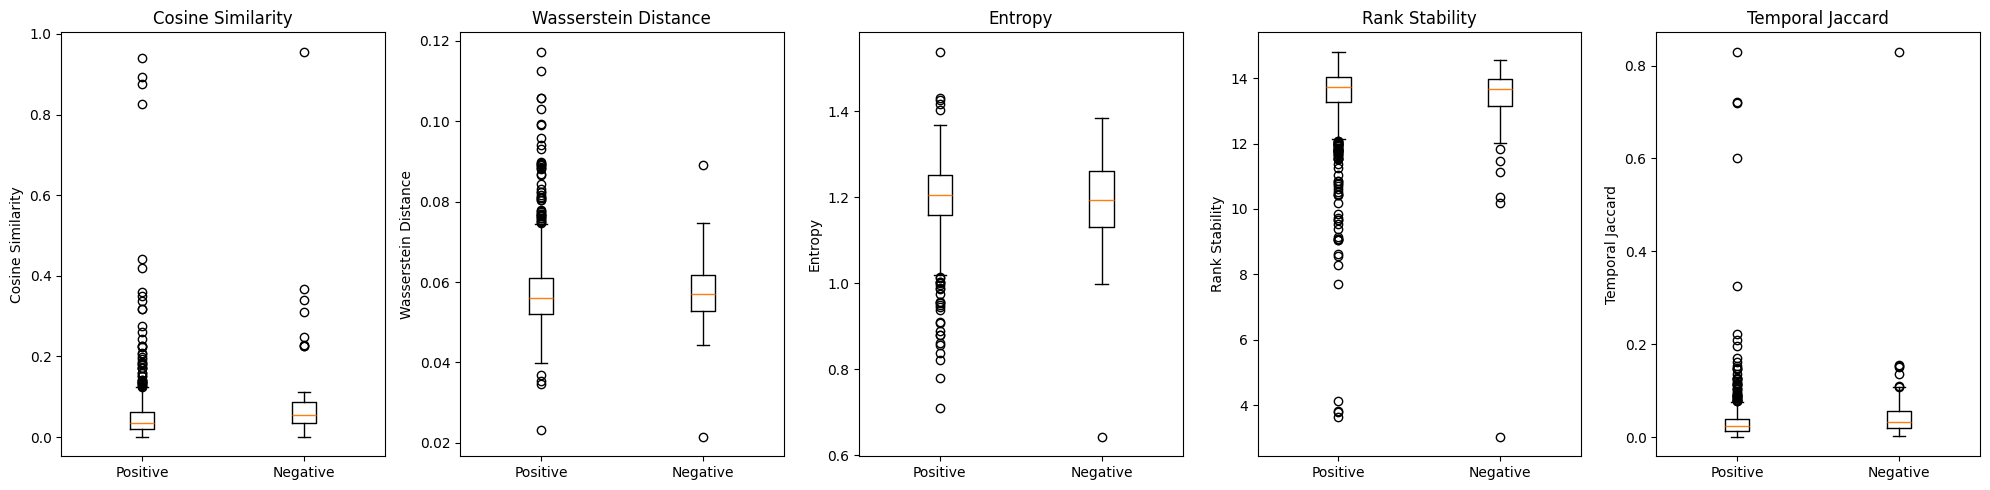

In [35]:
stats_results = {}
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
# Iterate through each metric
for i, (metric, readable_name) in enumerate(metrics.items()):
    # Extract values and drop NaNs
    pos_vals = positive_entropy[metric].dropna()
    neg_vals = negative_entropy[metric].dropna()
    # Compute statistical tests
    ks_stat, ks_p = ks_2samp(pos_vals, neg_vals)
    mw_stat, mw_p = mannwhitneyu(pos_vals, neg_vals, alternative='two-sided')
    # Compute Cohen's d
    def cohens_d(x, y):
        return (x.mean() - y.mean()) / np.sqrt((x.var() + y.var()) / 2)
    d = cohens_d(pos_vals, neg_vals)
    # Compute 95% Confidence Intervals
    ci_pos = norm.interval(0.95, loc=pos_vals.mean(), scale=pos_vals.std()/np.sqrt(len(pos_vals)))
    ci_neg = norm.interval(0.95, loc=neg_vals.mean(), scale=neg_vals.std()/np.sqrt(len(neg_vals)))
    # Store results
    stats_results[readable_name] = {
        'KS Test Statistic': ks_stat, 'KS Test p-value': ks_p,
        'Mann-Whitney U Statistic': mw_stat, 'Mann-Whitney p-value': mw_p,
        'Cohen’s d': d,
        '95% CI Positive': ci_pos, '95% CI Negative': ci_neg
    }
    # Boxplot
    axes[i].boxplot([pos_vals, neg_vals], tick_labels=['Positive', 'Negative'])
    axes[i].set(ylabel = readable_name, title = f'{readable_name}')
    #axes[i].set_title(f'{readable_name}')
    #axes[i].set_ylabel(readable_name)
# Adjust layout
plt.tight_layout()
plt.show()

In [36]:
stats_df = pd.DataFrame(stats_results).T
stats_df

,KS Test Statistic,KS Test p-value,Mann-Whitney U Statistic,Mann-Whitney p-value,Cohen’s d,95% CI Positive,95% CI Negative
Cosine Similarity,0.256376,0.001042,19728.0,0.000128,-0.39052,"(0.04588337598977935, 0.05493012474417023)","(0.05805214881743085, 0.12947891015213353)"
Wasserstein Distance,0.10476,0.538876,26234.0,0.402544,-0.002518,"(0.05684262268155228, 0.05804274966991682)","(0.05510364430202085, 0.0598288158835437)"
Entropy,0.087045,0.759191,28434.0,0.861617,0.066901,"(1.1899922631982849, 1.200488623944912)","(1.1622500306185968, 1.2156233317508303)"
Rank Stability,0.116577,0.404376,30963.0,0.18106,0.194654,"(13.410326299087076, 13.550100667160129)","(12.787152640781647, 13.627981239756545)"
Temporal Jaccard,0.189684,0.031658,21478.0,0.00249,-0.282948,"(0.029841186858157842, 0.03648317924832105)","(0.029527800003580518, 0.08519350149408667)"


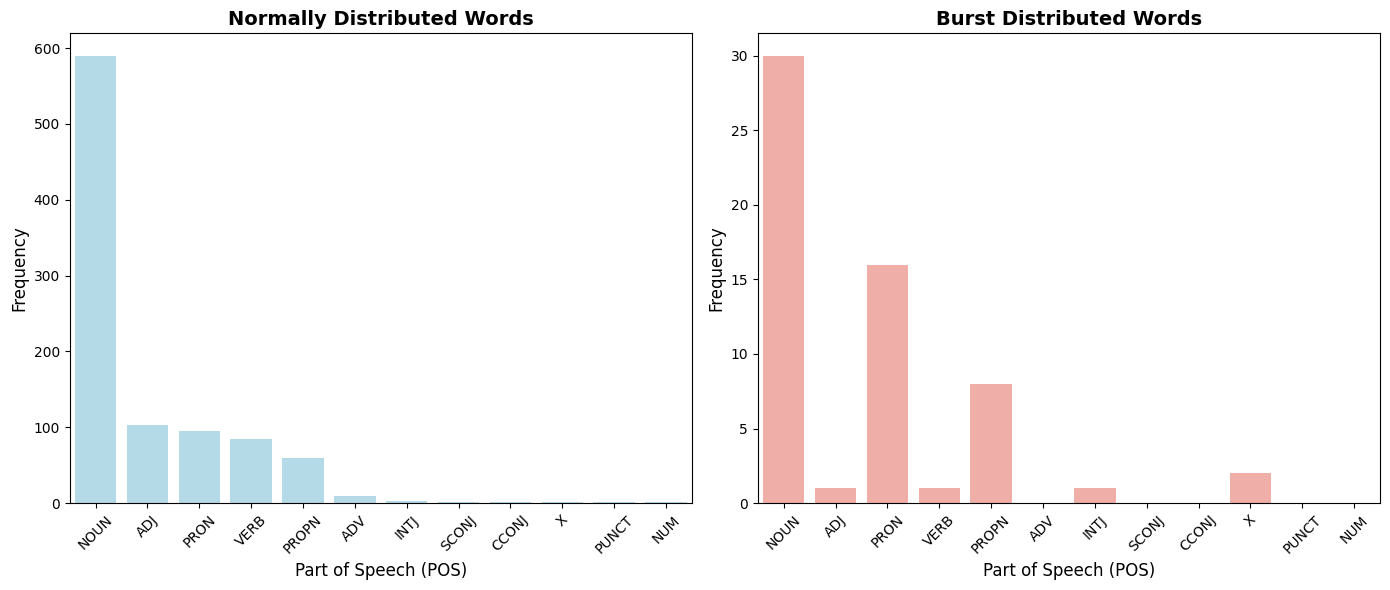

In [37]:
positive_pos = positive_entropy['First_Most_Common_POS'].dropna()
negative_pos = negative_entropy['First_Most_Common_POS'].dropna()
positive_pos_counts = positive_pos.value_counts()
negative_pos_counts = negative_pos.value_counts()

ordered_pos_tags = positive_pos_counts.index.tolist()  # Order by positive words frequency
# Create figure with two separate histograms (no shared y-axis)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram for positive entropy words
sns.barplot(x=positive_pos_counts.index, y=positive_pos_counts.values, color='skyblue', alpha=0.7, ax=axes[0], order=ordered_pos_tags)
axes[0].set_title("Normally Distributed Words", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Part of Speech (POS)", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot histogram for negative entropy words
sns.barplot(x=negative_pos_counts.index, y=negative_pos_counts.values, color='salmon', alpha=0.7, ax=axes[1], order=ordered_pos_tags)
axes[1].set_title("Burst Distributed Words", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Part of Speech (POS)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

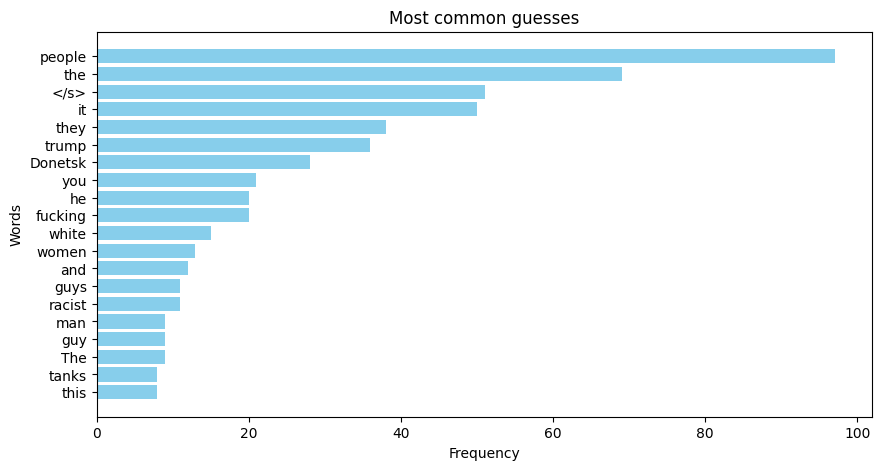

In [38]:
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
word_freq_df = word_freq_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(word_freq_df['Word'][:20], word_freq_df['Count'][:20], color='skyblue')
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.title('Most common guesses')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency words at the top
plt.show()

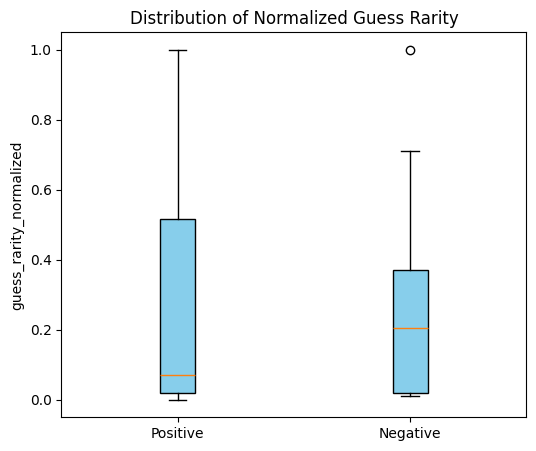

In [41]:
# Initialize dictionary to store statistical results
stats_results_guess_rarity = {}

# Extract values and drop NaNs
pos_vals = positive_entropy['guess_rarity_normalized'].dropna()
neg_vals = negative_entropy['guess_rarity_normalized'].dropna()

# Compute statistical tests
ks_stat, ks_p = ks_2samp(pos_vals, neg_vals)
mw_stat, mw_p = mannwhitneyu(pos_vals, neg_vals, alternative='two-sided')

d = cohens_d(pos_vals, neg_vals)

# Compute 95% Confidence Intervals
ci_pos = norm.interval(0.95, loc=pos_vals.mean(), scale=pos_vals.std()/np.sqrt(len(pos_vals)))
ci_neg = norm.interval(0.95, loc=neg_vals.mean(), scale=neg_vals.std()/np.sqrt(len(neg_vals)))

# Store results
stats_results_guess_rarity['guess_rarity_normalized'] = {
    'KS Test Statistic': ks_stat, 'KS Test p-value': ks_p,
    'Mann-Whitney U Statistic': mw_stat, 'Mann-Whitney p-value': mw_p,
    'Cohen’s d': d,
    '95% CI Positive': ci_pos, '95% CI Negative': ci_neg
}

# Set up figure for boxplot
plt.figure(figsize=(6, 5))
plt.boxplot([pos_vals, neg_vals], tick_labels=['Positive', 'Negative'], patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.ylabel('guess_rarity_normalized')
plt.title('Distribution of Normalized Guess Rarity')
plt.show()

In [42]:
stats_df = pd.DataFrame(stats_results_guess_rarity).T
stats_df

,KS Test Statistic,KS Test p-value,Mann-Whitney U Statistic,Mann-Whitney p-value,Cohen’s d,95% CI Positive,95% CI Negative
guess_rarity_normalized,0.112192,0.451926,27970.0,0.968922,0.130424,"(0.23942525193326875, 0.28089519209201114)","(0.1614380208443435, 0.28413248413556214)"


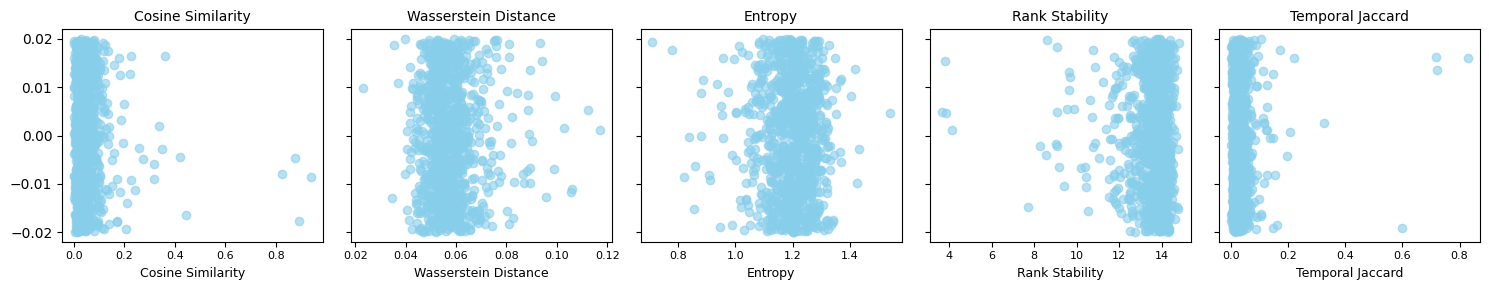

In [43]:
# Extract only positive entropy words
pos_entropy_df = positive_entropy.copy()

# Set up subplots for scatterplots (5 in one row)
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 3), sharey=True)

for i, (metric, readable_name) in enumerate(metrics.items()):
    values = pos_entropy_df[metric].dropna()
    jitter = np.random.uniform(-0.02, 0.02, size=len(values))  # Add jitter to Y for visibility

    axes[i].scatter(values, jitter, alpha=0.6, color='skyblue')
    axes[i].set_xlabel(readable_name, fontsize=9)
    axes[i].set_title(readable_name, fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

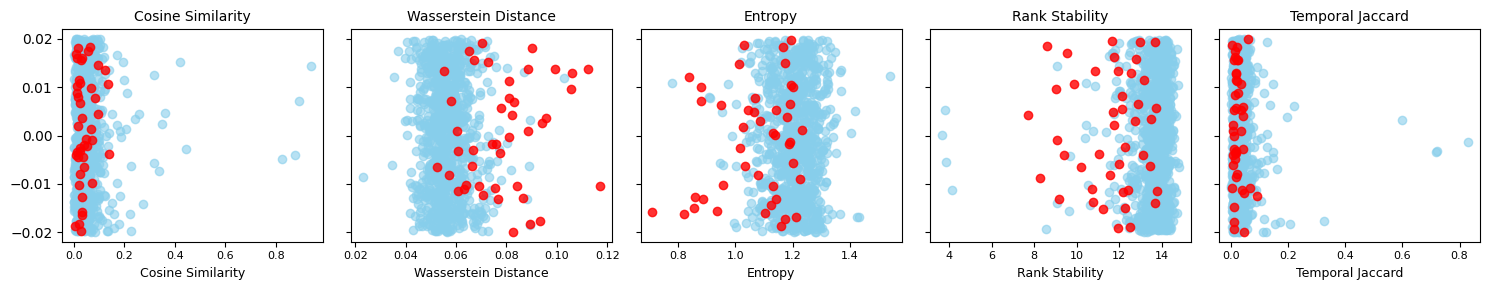

In [44]:
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 3), sharey=True)

for i, (metric, readable_name) in enumerate(metrics.items()):
    # Drop rows where the metric is NaN
    valid_data = pos_entropy_df[[metric, 'First_First_Guess_Guess']].dropna()
    
    # Extract values
    values = valid_data[metric]
    jitter = np.random.uniform(-0.02, 0.02, size=len(values))  # Jitter for visibility
    
    # Separate red and skyblue points
    is_red = valid_data['First_First_Guess_Guess'] == "</s>"
    
    # Plot skyblue points first (behind)
    axes[i].scatter(values[~is_red], jitter[~is_red], alpha=0.6, color='skyblue')
    
    # Plot red points on top
    axes[i].scatter(values[is_red], jitter[is_red], alpha=0.8, color='red')
    
    axes[i].set_xlabel(readable_name, fontsize=9)
    axes[i].set_title(readable_name, fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

In [65]:
len(negative_entropy)

59

In [58]:
features = [
    "First_Cosine_Similarity_Mean", 
    "First_Rank_Stability_Mean", 
    "First_Temporal_Jaccard_Mean"
]

full_df = merged_df.copy()

full_df["Negative_Entropy_Label"] = (full_df['normalized_time_entropy_zscore'] < 0).astype(int)
df_clean = full_df.dropna(subset=features + ["Negative_Entropy_Label"])

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_clean[features], df_clean["Negative_Entropy_Label"], test_size=0.2, random_state=42
)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.4f}")

# Print detailed classification report
print(classification_report(y_test, y_pred))

feature_importances = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

Classification Accuracy: 0.9491
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       205
           1       0.00      0.00      0.00        11

    accuracy                           0.95       216
   macro avg       0.47      0.50      0.49       216
weighted avg       0.90      0.95      0.92       216



/Users/easy/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/easy/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/easy/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clean[features], df_clean["normalized_time_entropy_zscore"], test_size=0.2, random_state=42
)

# Train Random Forest Regression model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on test set
y_pred = rf_regressor.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance analysis
feature_importances = pd.DataFrame({'Feature': features, 'Importance': rf_regressor.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

ValueError: Input y contains NaN.